# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler     
from sklearn.tree import DecisionTreeClassifier      
from sklearn.metrics import f1_score                 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.utils import shuffle                   
from sklearn.metrics import roc_curve                
from sklearn.metrics import roc_auc_score           
pd.options.mode.chained_assignment = None            
import seaborn as sns  
pd.set_option('display.float_format', '{:,.2f}'.format)
import warnings

warnings.filterwarnings('ignore')

In [29]:
# чтение файла с данными и сохранение в DataFrame
df = pd.read_csv('/datasets/Churn.csv',index_col=0)

In [30]:
# получение первых 5 строк таблицы df
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [32]:
df.describe(include='all')

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00",10000,"10,000.00",10000,10000,"10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
unique,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"15,690,940.57",NaN,650.53,NaN,NaN,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"71,936.19",NaN,96.65,NaN,NaN,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,"15,565,701.00",NaN,350.00,NaN,NaN,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"15,628,528.25",NaN,584.00,NaN,NaN,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"15,690,738.00",NaN,652.00,NaN,NaN,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"15,753,233.75",NaN,718.00,NaN,NaN,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00


**Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.**

Описание данных:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**- Целевой признак Exited — факт ухода клиента**

In [33]:
# Посмотрим тип данных в столбцах
df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [34]:
# Посмотрим значения по столбцу Geography
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [35]:
# Посмотрим значения по столбцу Gender
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [36]:
# удалим колонки CustomerId, Surname. Предполагаем, что id и фамилия клиента не влияют на факт ухода клиента
df.drop(columns=['CustomerId', 'Surname'],axis=1,inplace=True)
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
2,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
3,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
4,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
5,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [37]:
# Применим one hot encoding к датафрейму, что бы избежать "ловушку фиктивных признаков"
df_ohe=pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
2,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,1,0
3,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
4,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
5,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,1,0


In [38]:
# Проверим, что в датафрейме отсутствуют пропущенные значения
df_ohe.isna().sum()

CreditScore            0
Age                    0
Tenure               909
Balance                0
NumOfProducts          0
HasCrCard              0
IsActiveMember         0
EstimatedSalary        0
Exited                 0
Geography_Germany      0
Geography_Spain        0
Gender_Male            0
dtype: int64

In [39]:
# посмотрим статистики по столбцу Tenure
df_ohe['Tenure'].describe()

count   9,091.00
mean        5.00
std         2.89
min         0.00
25%         2.00
50%         5.00
75%         7.00
max        10.00
Name: Tenure, dtype: float64

In [40]:
# посмотрим значения по столбцу Tenure
df_ohe['Tenure'].value_counts()

1.00     952
2.00     950
8.00     933
3.00     928
5.00     927
7.00     925
4.00     885
9.00     882
6.00     881
10.00    446
0.00     382
Name: Tenure, dtype: int64

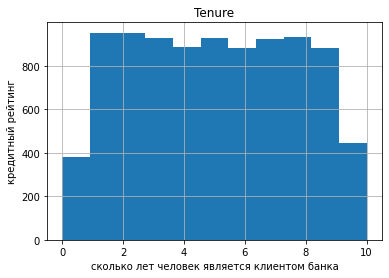

In [41]:
# построим гистограмму по столбцу Tenure
tenure_hist = df_ohe['Tenure'].hist(bins=11)
plt.title('Tenure')
tenure_hist.set_ylabel('кредитный рейтинг')
tenure_hist.set_xlabel('сколько лет человек является клиентом банка')
plt.show()

Значение 'Tenure' ни как не коррелирует с остальными значениями в данных. 
Система банка при формировании значения сколько лет, существует данный клиент, не заполняет значения "0". Т.е. 382 клиента пользуются услугами банка меньше года.
Таким образом вывести закономерности не возможно. Просто присвоить медианное, среднее, min или max, тоже не правильно так как таких значений около 10% и мы можем изменить статистику данных. Удалить - мне кажется это тоже не самое верное решение. Потому, что таких значений хоть и меньше 10%, но все таки они логичгые по заполнению! Мы потерям коло 10% базы.
Поэтому, все таки заполню их случайными числами.

In [42]:
df_ohe['Tenure']=df_ohe['Tenure'].fillna(df_ohe['Tenure'].median())

In [43]:
#Заполним пропуски случайными значениями
#data = (np.random.randint(0,10,size=df_ohe['Tenure'].isna().sum()))
#df_ohe.loc[df_ohe['Tenure'].isna(),'Tenure']=data

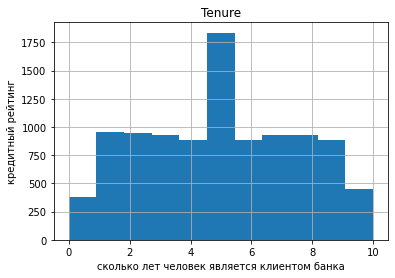

In [44]:
# Посмотрим повторно гистограмму по столбцу Tenure
tenure_hist = df_ohe['Tenure'].hist(bins=11)
plt.title('Tenure')
tenure_hist.set_ylabel('кредитный рейтинг')
tenure_hist.set_xlabel('сколько лет человек является клиентом банка')
plt.show()

In [45]:
#Еще раз проверим пропущенные значения
df_ohe.isna().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

In [46]:
# Создадим список с числовыми столбцами
numeric = ['CreditScore','Age','Balance','NumOfProducts','EstimatedSalary','Tenure']

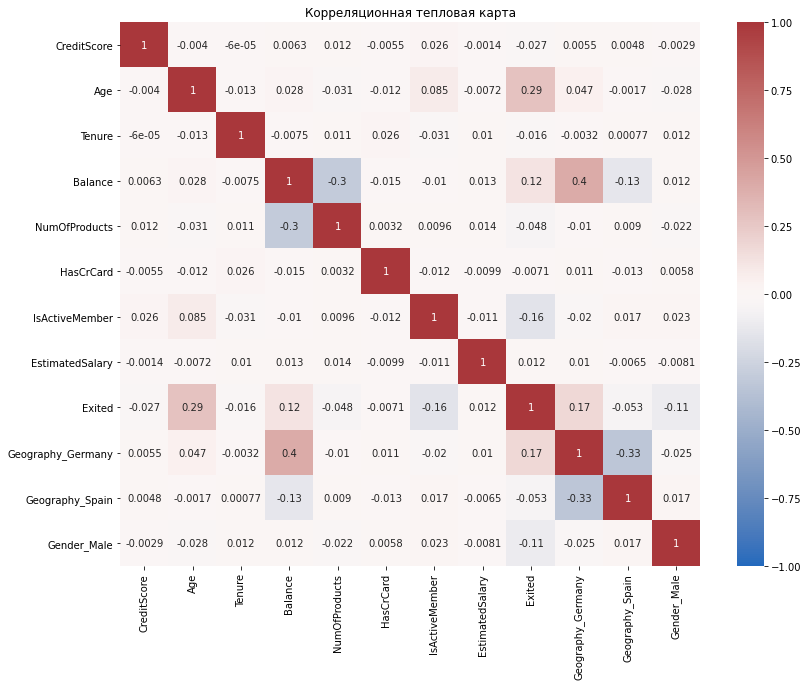

In [47]:
fig, ax = plt.subplots(figsize=(13,10))
heatmap = sns.heatmap(df_ohe.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Корреляционная тепловая карта')
plt.show()

Корреляции между числовыми столбцами не обнаружено, самое больше значение 0,4 это корреляция между Количеством продуктов и балансом на счете. Проверим наличие ложной корреляции, посмотрим скатерплоты

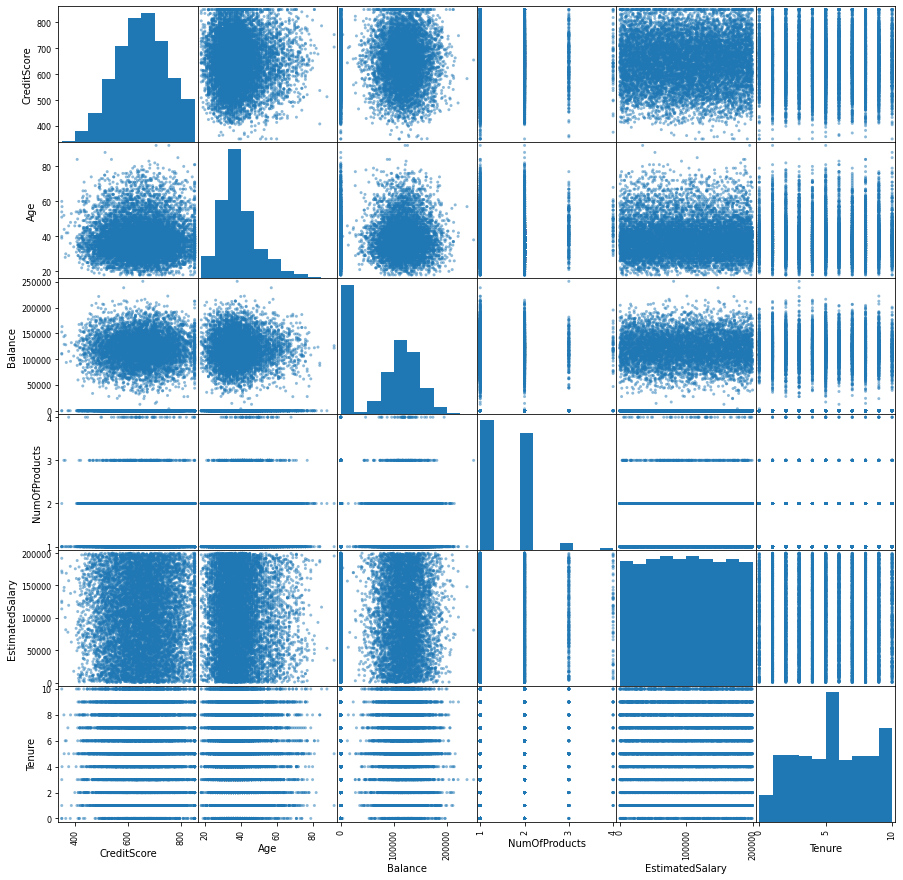

In [48]:
pd.plotting.scatter_matrix(df_ohe.loc[:,numeric],figsize=(15,15))
plt.show()

По графикам так же не обнаружено ложной корреляции между столбцами, все числовые столбцы оставляем в датафрейме для обучения модели.

**Вывод:** Видно что данные достаточно хорошо подобраны для обучения студентов. Данных достаточно, распределения  аккуратны, мультиколлинеарности не наблюдается. Можно приступать к основной части задания.

## Исследование задачи

In [49]:
#Сохраним признаки
#целевой признак
target = df_ohe['Exited']
#признаки
features = df_ohe.drop(['Exited'], axis=1)

In [50]:
#Зафиксируем randome_state
np.random.seed(274)
RANDOM_STATE = 42

In [51]:
#Посчитаем количество значений в целевом признаке, это покажет баланс значений.
churn_count = df_ohe[target == 1].shape[0]
non_churn_count = df_ohe[target == 0].shape[0]
print('Отток:', churn_count)
print('Не отток:', non_churn_count)

Отток: 2037
Не отток: 7963


**Видно, что классы несбалансированы, гораздо больше пользователей соответсвующих классу "не отток". Дисбкаланс классов может повлиять на обучение моделей. Сначала проверим модели как есть, с присутствующим дисбалансом.**

In [52]:
#разобьем исходные данные на три выборки: обучающую, валидационную (проверочную) и тестовую (60% / 20% / 20%)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=12345, stratify=target_valid)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


В результате получили три набора данных: обучающий,валидационный и тестовый.
Теперь можно приступить к обучению, но сначала стандартизируем признаки:

In [53]:
#стандартизируем признаки
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [54]:
features_test.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
658,-0.50,1.43,-1.46,0.87,0.82,1,1,1.73,1,0,0
2084,-1.20,-1.43,-1.46,-1.22,-0.91,1,1,1.20,0,0,1
3235,-1.27,0.76,-1.46,-1.22,-0.91,1,0,-1.37,0,0,1
1552,0.83,1.24,0.72,-1.22,0.82,0,1,0.38,0,1,0
2345,0.66,0.95,-0.37,0.27,-0.91,1,0,-1.61,1,0,0


**Построим модели и посчитаем их метрики.** 
Будем использовать следующие модели:

- Случайный лес (RandomForestClassifier);
- Модель решающего дерева, (DecisionTreeClassifier);
- Логистическая регрессия, (LogisticRegression);

Для начала обучим модели с несбалансированными классами, посмотрим что получится и после приступим к работе с балансировкой.

In [55]:
# лучшая модель
best_model = None
best_result = 0

**Модель решающего дерева**

In [56]:
# лучший результат
DecisionTree_result = 0
# глубина дерева
DecisionTree_depth = 0

# найдем оптимальные значения гиперпараметров в цикле
for depth in range(1, 50):
    #модель решающего дерева
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train, target_train)
    
    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > DecisionTree_result:
        DecisionTree_result = result
        DecisionTree_depth = depth
    
if DecisionTree_result > best_result:
    best_result = DecisionTree_result
    best_model = model

        
print('Лучшая F1-мера:', f'{DecisionTree_result:.4f}')
print('Оптимальное значение глубины дерева:', DecisionTree_depth)

Лучшая F1-мера: 0.5937
Оптимальное значение глубины дерева: 7


**Модель случайного леса**

In [57]:
# лучший результат
RandomForest_result = 0
# глубина дерева
RandomForest_depth = 0
# количество деревьев
RandomForest_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(5, 100, 5):
    for depth in range(1, 20):
        # модель леса
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        
        # посчитаем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        
        # сравним результаты
        if result > RandomForest_result:
            RandomForest_result = result
            RandomForest_depth = depth
            RandomForest_est = est
        
# сохраним в лучшую модель    
if RandomForest_result > best_result:
    best_result = RandomForest_result
    best_model = model

print('Лучшая F1-мера:' f'{RandomForest_result:.4f}')
print('Оптимальная глубина дерева:', RandomForest_depth)
print('Оптимальное количество деревьев:', RandomForest_est)

Лучшая F1-мера:0.6263
Оптимальная глубина дерева: 15
Оптимальное количество деревьев: 45


**Модель логистической регрессии**

In [58]:
# лучший результат
LogisticRegression_result = 0

# лучший алгоритм оптимизации
solver = ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
best_solver = []

for i in range(len(solver)):
    # модель логистической регрессии
    model = LogisticRegression(random_state=RANDOM_STATE, solver=solver[i], max_iter=500)
    model.fit(features_train, target_train)

    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > LogisticRegression_result:
        LogisticRegression_result = result
        best_solver = solver[i]
                
# сохраним в лучшую модель    
if LogisticRegression_result > best_result:
    best_result = LogisticRegression_result
    best_model = model
    
print('Лучшая F1-мера:',f'{LogisticRegression_result:.2f}')
print('Лучший алгоритм оптимизации:', best_solver)

Лучшая F1-мера: 0.31
Лучший алгоритм оптимизации: liblinear


**Вывод**

In [59]:
print('Лучшая F1-мера на обучающей выборке у', best_model,
      'с результатом:', f'{best_result:.4f}')

Лучшая F1-мера на обучающей выборке у RandomForestClassifier(max_depth=19, n_estimators=95, random_state=42) с результатом: 0.6263


In [60]:
raw_probabilities_valid = best_model.predict_proba(features_valid)
raw_probabilities_one_valid = raw_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, raw_probabilities_one_valid)
raw_auc_roc = roc_auc_score(target_valid, raw_probabilities_one_valid)

print('AUC-ROC =', f'{raw_auc_roc:.4f}')

AUC-ROC = 0.8621


В несбалансированных классах лучшей моделью оказался случайный лес. AUC-ROC лучшей несбалансированной модели - 0.8626

Переходим к борьбе с дисбалансом.

## Борьба с дисбалансом

Несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Для решения этой проблемы попробуем по-разному изменять вес значений классов "отток", "не отток".
1. используем `Upsampling`;
2. затем `Downsampling`;
3. и взвесим `class_weight='balanced'`

**Upsampling**

In [61]:
# увеличим вес значения "отток".
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)


print(target_upsampled.value_counts())

1    6110
0    4778
Name: Exited, dtype: int64


In [62]:
# лучшая модель
best_up_model = None
best_up_result = 0

**Модель решающего дерева**

In [63]:
# лучший результат
DecisionTree_up_result = 0
# глубина дерева
DecisionTree_up_depth = 0

# найдем оптимальные значения гиперпараметров в цикле
for depth in range(1, 50):
    #модель решающего дерева
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    
    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > DecisionTree_up_result:
        DecisionTree_up_result = result
        DecisionTree_up_depth = depth
    
if DecisionTree_up_result > best_up_result:
    best_up_result = DecisionTree_up_result
    best_up_model = model

        
print('Лучшая F1-мера расширенной выборки:', f'{DecisionTree_up_result:.4f}')
print('Оптимальное значение глубины дерева:', DecisionTree_up_depth)

Лучшая F1-мера расширенной выборки: 0.5763
Оптимальное значение глубины дерева: 6


**Модель случайного леса**

In [64]:
# лучший результат
RandomForest_up_result = 0
# глубина дерева
RandomForest_up_depth = 0
# количество деревьев
RandomForest_up_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(5, 100, 5):
    for depth in range(1, 20):
        # модель леса
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        
        # посчитаем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        
        # сравним результаты
        if result > RandomForest_up_result:
            RandomForest_up_result = result
            RandomForest_up_depth = depth
            RandomForest_up_est = est
        
# сохраним в лучшую модель    
if RandomForest_up_result > best_up_result:
    best_up_result = RandomForest_up_result
    best_up_model = model

print('Лучшая F1-мера расширенной выборки:' f'{RandomForest_up_result:.4f}')
print('Оптимальная глубина дерева:', RandomForest_up_depth)
print('Оптимальное количество деревьев:', RandomForest_up_est)

Лучшая F1-мера расширенной выборки:0.6463
Оптимальная глубина дерева: 12
Оптимальное количество деревьев: 50


**Модель логистической регрессии**

In [65]:
# лучший результат
LogisticRegression_up_result = 0

# лучший алгоритм оптимизации
solver = ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
best_up_solver = []

for i in range(len(solver)):
    # модель логистической регрессии
    model = LogisticRegression(random_state=RANDOM_STATE, solver=solver[i], max_iter=500)
    model.fit(features_upsampled, target_upsampled)

    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > LogisticRegression_up_result:
        LogisticRegression_up_result = result
        best_up_solver = solver[i]
                
# сохраним в лучшую модель    
if LogisticRegression_up_result > best_result:
    best_up_result = LogisticRegression_up_result
    best_up_model = model
    
print('Лучшая F1-мера расширенной выборки:',f'{LogisticRegression_up_result:.2f}')
print('Лучший алгоритм оптимизации:', best_up_solver)

Лучшая F1-мера расширенной выборки: 0.50
Лучший алгоритм оптимизации: sag


**Вывод**

In [66]:
print('Лучшая F1-мера на расширенной обучающей выборке у', best_up_model,
      'с результатом:', f'{best_up_result:.4f}')

Лучшая F1-мера на расширенной обучающей выборке у RandomForestClassifier(max_depth=19, n_estimators=95, random_state=42) с результатом: 0.6463


На увеличенной выборке две модели улучшили F1-меру, кроме решающего дерева.

In [67]:
# Уменьшаем количество значений целевого признака
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.15)


print(target_downsampled.value_counts())

1    1222
0     717
Name: Exited, dtype: int64


In [68]:
# лучшая модель
best_down_model = None
best_down_result = 0

**Модель решающего дерева**

In [69]:
# лучший результат
DecisionTree_down_result = 0
# глубина дерева
DecisionTree_down_depth = 0

# найдем оптимальные значения гиперпараметров в цикле
for depth in range(1, 50):
    #модель решающего дерева
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    
    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > DecisionTree_down_result:
        DecisionTree_down_result = result
        DecisionTree_down_depth = depth
    
if DecisionTree_result > best_down_result:
    best_down_result = DecisionTree_down_result
    best_down_model = model

        
print('Лучшая F1-мера на уменьшеной выборке:', f'{DecisionTree_down_result:.4f}')
print('Оптимальное значение глубины дерева:', DecisionTree_down_depth)

Лучшая F1-мера на уменьшеной выборке: 0.5546
Оптимальное значение глубины дерева: 5


**Модель случайного леса**

In [70]:
# лучший результат
RandomForest_down_result = 0
# глубина дерева
RandomForest_down_depth = 0
# количество деревьев
RandomForest_down_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(5, 100, 5):
    for depth in range(1, 20):
        # модель леса
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        
        # посчитаем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        
        # сравним результаты
        if result > RandomForest_down_result:
            RandomForest_down_result = result
            RandomForest_down_depth = depth
            RandomForest_down_est = est
        
# сохраним в лучшую модель    
if RandomForest_down_result > best_down_result:
    best_down_result = RandomForest_down_result
    best_down_model = model

print('Лучшая F1-мера на уменьшеной выборке:' f'{RandomForest_down_result:.4f}')
print('Оптимальная глубина дерева:', RandomForest_down_depth)
print('Оптимальное количество деревьев:', RandomForest_down_est)

Лучшая F1-мера на уменьшеной выборке:0.5463
Оптимальная глубина дерева: 16
Оптимальное количество деревьев: 40


**Модель логистической регрессии**

In [71]:
# лучший результат
LogisticRegression_down_result = 0

# лучший алгоритм оптимизации
solver = ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
best_down_solver = []

for i in range(len(solver)):
    # модель логистической регрессии
    model = LogisticRegression(random_state=RANDOM_STATE, solver=solver[i], max_iter=500)
    model.fit(features_downsampled, target_downsampled)

    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > LogisticRegression_down_result:
        LogisticRegression_down_result = result
        best_down_solver = solver[i]
                
# сохраним в лучшую модель    
if LogisticRegression_down_result > best_down_result:
    best_down_result = LogisticRegression_down_result
    best_down_model = model
    
print('Лучшая F1-мера на уменьшеной выборке:',f'{LogisticRegression_down_result:.2f}')
print('Лучший алгоритм оптимизации:', best_down_solver)

Лучшая F1-мера на уменьшеной выборке: 0.48
Лучший алгоритм оптимизации: liblinear


**Вывод**

In [72]:
print('Лучшая F1-мера на уменьшеной обучающей выборке у', best_down_model,
      'с результатом:', f'{best_down_result:.4f}')

Лучшая F1-мера на уменьшеной обучающей выборке у DecisionTreeClassifier(max_depth=49, random_state=42) с результатом: 0.5546


Значительное падение F-меры на уменьшеной выборке у каждой модели. Разбаллансирока имеет значение и в данном случае это наглядно видно!

**class_weight**

In [73]:
# лучшая модель
best_weight_model = None
best_weight_result = 0

**Модель решающего дерева**

In [74]:
# лучший результат
DecisionTree_weight_result = 0
# глубина дерева
DecisionTree_weight_depth = 0

# найдем оптимальные значения гиперпараметров в цикле
for depth in range(1, 50):
    #модель решающего дерева
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    
    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > DecisionTree_weight_result:
        DecisionTree_weight_result = result
        DecisionTree_weight_depth = depth
    
if DecisionTree_weight_result > best_weight_result:
    best_weight_result = DecisionTree_weight_result
    best_weight_model = model

        
print('Лучшая F1-мера с увеличенным весом редких объектов:', f'{DecisionTree_weight_result:.4f}')
print('Оптимальное значение глубины дерева:', DecisionTree_weight_depth)

Лучшая F1-мера с увеличенным весом редких объектов: 0.5754
Оптимальное значение глубины дерева: 6


**Модель случайного леса**

In [75]:
# лучший результат
RandomForest_weight_result = 0
# глубина дерева
RandomForest_weight_depth = 0
# количество деревьев
RandomForest_weight_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(5, 100, 5):
    for depth in range(1, 20):
        # модель леса
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        
        # посчитаем качество модели на валидационной выборке
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        
        # сравним результаты
        if result > RandomForest_weight_result:
            RandomForest_weight_result = result
            RandomForest_weight_depth = depth
            RandomForest_weight_est = est
        
# сохраним в лучшую модель    
if RandomForest_weight_result > best_weight_result:
    best_weight_result = RandomForest_weight_result
    best_weight_model = model

print('Лучшая F1-мера с увеличенным весом редких объектов:' f'{RandomForest_weight_result:.4f}')
print('Оптимальная глубина дерева:', RandomForest_weight_depth)
print('Оптимальное количество деревьев:', RandomForest_weight_est)

Лучшая F1-мера с увеличенным весом редких объектов:0.6476
Оптимальная глубина дерева: 9
Оптимальное количество деревьев: 85


**Модель логистической регрессии**

In [76]:
# лучший результат
LogisticRegression_weight_result = 0

# лучший алгоритм оптимизации
solver = ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
best_weight_solver = []

for i in range(len(solver)):
    # модель логистической регрессии
    model = LogisticRegression(random_state=RANDOM_STATE, solver=solver[i], max_iter=500, class_weight='balanced')
    model.fit(features_train, target_train)

    # посчитаем качество модели на валидационной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    
    # сравним результаты
    if result > LogisticRegression_weight_result:
        LogisticRegression_weight_result = result
        best_weight_solver = solver[i]
                
# сохраним в лучшую модель    
if LogisticRegression_result > best_weight_result:
    best_weight_result = LogisticRegression_weight_result
    best_weight_model = model
    
print('Лучшая F1-мера с увеличенным весом редких объектов:',f'{LogisticRegression_weight_result:.2f}')
print('Лучший алгоритм оптимизации:', best_weight_solver)

Лучшая F1-мера с увеличенным весом редких объектов: 0.53
Лучший алгоритм оптимизации: liblinear


**Вывод**

In [77]:
print('Лучшая F1-мера с увеличенным весом редких объектов\n у', best_weight_model,
      'с результатом:', f'{best_weight_result:.4f}')

Лучшая F1-мера с увеличенным весом редких объектов
 у RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=95,
                       random_state=42) с результатом: 0.6476


Лучшая F-мера у **RandomForestClassifier** с увеличенным весом с результатом: 0.6468. Построим ROC-криваую:

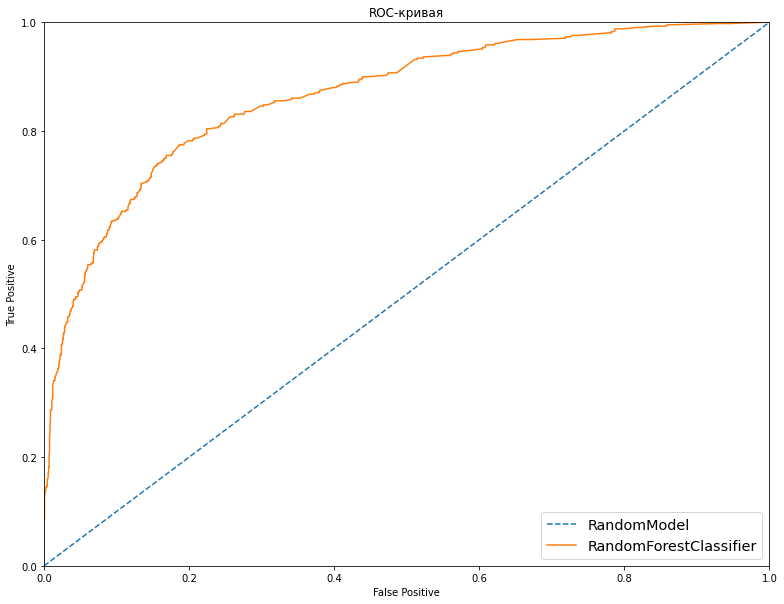

AUC-ROC =   0.8647


In [78]:
# ROC-кривая лучшей модели
plt.figure(figsize=[13,10])
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
best_weight_model.fit(features_train, target_train)
probabilities_valid = best_weight_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


# ROC-кривая случайной модели
plt.plot(fpr, tpr, label='RandomForestClassifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC-кривая')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

print('AUC-ROC =  ', f'{auc_roc:.4f}')

**Вывод**

Борьба с дисбалансом дала свои результаты: `Upsamling` и `Downsampling` показали себя не так хорошо как развесовка значений.

После борьбы с дисбалансом у нас определилась **лучшая модель**, это **RandomForestClassifier с результатом: 0.6468.**

## Тестирование модели

Проведем финальное тестирование лучшей модели:

In [80]:
best_weight_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=85, max_depth = 5, class_weight='None')
best_weight_model.fit(features_train, target_train)


full_predictions = best_weight_model.predict(features_test) 
full_result = f1_score(target_test, full_predictions)

print("Лучшая F1-мера:", full_result)

full_probabilities_test = best_weight_model.predict_proba(features_test)
full_probabilities_one_test = full_probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, full_probabilities_one_test)
full_auc_roc = roc_auc_score(target_test, full_probabilities_one_test)

print('AUC-ROC =', full_auc_roc)

Лучшая F1-мера: 0.5918854415274463
AUC-ROC = 0.855397770652008


**Вывод**

По результатам работы проведена подготовка данных. При аналазе выяснилось, что данные дисбалансы. Обучили несколько моделей (подбор гиперпараметров провели в цикле), проверили работу моделей на данных с балансом и без. 

Среди моделей абсолютным лидером стал **RandomForestClassifier**. На баллансных и дисбалансных данных он показывал лучшие результаты.

Лучшим методом борьбы с дисбалансом стал  **class_weight** - гиперпараметр, который позволяет увеличить вес редких объектов. 

Лучшая **F1-мера** у **RandomForestClassifier**. По результату тестирования модели получено значение в **0.592**, что  вполне удовлевтвояряет условию поставленной задачи. **AUC-ROC** модели равен **0.8619**. Весьма неплохой результат. Подученную модель можно использовать для предсказания "уйдет клиент из «Бета-Банка» или нет".